In [1]:
import cfp
import scanpy as sc
import anndata as ad
import numpy as np

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
combosciplex_color_dict = {
    'Alvespimycin+Pirarubicin': '#fa0e03',
    'Cediranib+PCI-34051': '#0d3290',
    'Dacinostat+Danusertib': '#33ff57',
    'Dacinostat+Dasatinib': '#6300b5',
    'Dacinostat+PCI-34051': '#88e200',
    'Givinostat+Carmofur': '#8e3101',
    'Givinostat+Cediranib': '#1F7530',
    'Givinostat+Crizotinib': '#6ca05c',
    'Givinostat+Curcumin': '#03cd4A',
    'Givinostat+Dasatinib': '#9106eb',
    'Givinostat+SRT1720': '#EB984E',
    'Givinostat+SRT2104': '#260374',
    'Givinostat+Sorafenib': '#ff5733', 
    'Givinostat+Tanespimycin': '#a3e3af',
    'Panobinostat+Alvespimycin': '#46adaf',
    'Panobinostat+Crizotinib': '#8E1382',
    'Panobinostat+Curcumin': '#bdfd0b',
    'Panobinostat+Dasatinib': '#ce606c',
    'Panobinostat+PCI-34051': '#795548',
    'Panobinostat+SRT1720': '#22bb34',
    'Panobinostat+SRT2104': '#8D6E63',
    'Panobinostat+SRT3025': '#9d8303',
    'Panobinostat+Sorafenib': '#d7fdfd',
    'SRT2104+Alvespimycin': '#f502f3',
    'SRT3025+Cediranib': '#f502f3',
    'control+Alvespimycin': '#6ea3fa',
    'control+Dacinostat': '#d6a5fa',
    'control+Dasatinib': '#2d62a3',
    'control+Givinostat': '#5deb2e',
    'control+Panobinostat': '#b1cd3f',
    'control+SRT2104': '#7788cd',
    'control': "#8f97a8"
}


In [2]:
split = 3
model_name = "graceful-violet-300"

In [3]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"
adata_train = sc.read_h5ad(adata_train_path)
adata_test = sc.read_h5ad(adata_test_path)
adata_ood = sc.read_h5ad(adata_ood_path)
    

In [4]:
def prepare_data(adata_train, adata_test, adata_ood):
    
    adata_tmp =  adata_train[adata_train.obs["Drug1"].drop_duplicates().index]
    ecfp_dict = {drug: adata_tmp[adata_tmp.obs["Drug1"]==drug].obsm["ecfp_drug_1"] for drug in adata_tmp.obs["Drug1"]}

    adata_tmp =  adata_train[adata_train.obs["Drug2"].drop_duplicates().index]
    ecfp_dict.update({drug: adata_tmp[adata_tmp.obs["Drug2"]==drug].obsm["ecfp_drug_2"] for drug in adata_tmp.obs["Drug2"]})

    adata_tmp =  adata_ood[adata_ood.obs["Drug1"].drop_duplicates().index]
    ecfp_dict.update({drug: adata_tmp[adata_tmp.obs["Drug1"]==drug].obsm["ecfp_drug_1"] for drug in adata_tmp.obs["Drug1"]})

    adata_tmp =  adata_ood[adata_ood.obs["Drug2"].drop_duplicates().index]
    ecfp_dict.update({drug: adata_tmp[adata_tmp.obs["Drug2"]==drug].obsm["ecfp_drug_2"] for drug in adata_tmp.obs["Drug2"]})

        
    adata_train.uns['ecfp_rep'] = ecfp_dict
    adata_test.uns['ecfp_rep'] = ecfp_dict
    adata_ood.uns['ecfp_rep'] = ecfp_dict
    return adata_train, adata_test, adata_ood

adata_train, adata_test, adata_ood = prepare_data(adata_train, adata_test, adata_ood)

In [5]:
adata_ood_ctrl = adata_ood[adata_ood.obs["condition"]=="control"]
adata_test_ctrl = adata_test[adata_test.obs["condition"]=="control"]
adata_ood_ctrl.obs["control"] = True
adata_test_ctrl.obs["control"] = True
covariate_data_ood = adata_ood[adata_ood.obs["condition"]!="control"].obs.drop_duplicates(subset=["condition"])
covariate_data_test = adata_test[adata_test.obs["condition"]!="control"].obs.drop_duplicates(subset=["condition"])

/tmp/ipykernel_2105356/3998593493.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ood_ctrl.obs["control"] = True
/tmp/ipykernel_2105356/3998593493.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test_ctrl.obs["control"] = True


In [6]:
# temporary fix
adata_ood_ctrl.obsm["X_pca_use"] = adata_ood_ctrl.obsm["X_pca"]
adata_test_ctrl.obsm["X_pca_use"] = adata_test_ctrl.obsm["X_pca"]

In [7]:
cf = cfp.model.CellFlow.load(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/{model_name}_CellFlow.pkl")

In [8]:
condition_embedding_ood = cf.get_condition_embedding(covariate_data=covariate_data_ood, condition_id_key="condition", rep_dict=adata_train.uns)

/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 7/7 [00:00<00:00, 141.80it/s]


In [9]:
condition_embedding_train = cf.get_condition_embedding(covariate_data=covariate_data_test, condition_id_key="condition", rep_dict=adata_train.uns)

/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 24/24 [00:00<00:00, 1041.15it/s]


In [10]:
condition_embedding_train

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
condition,,,,,,,,,,,,,,,,,,,,,
control+Panobinostat,-0.065851,0.093432,0.070940,0.015050,-0.029860,0.065578,-0.133805,0.124684,0.162144,0.057902,...,0.064464,0.058650,0.062395,0.135613,-0.015411,0.161919,0.095210,-0.088973,0.176529,0.078379
Dacinostat+PCI-34051,-0.051831,0.075074,0.196367,-0.105981,0.065105,-0.032872,-0.014661,0.074427,0.081477,0.014220,...,-0.078002,0.088564,0.115534,0.005865,0.012597,0.084751,0.138078,0.077968,0.081665,0.043688
Panobinostat+PCI-34051,-0.085379,0.092720,0.045955,-0.010191,-0.079097,0.129343,-0.188612,0.128739,0.148452,0.125378,...,0.072976,0.045673,-0.035753,0.182319,-0.072187,0.138169,0.046464,-0.111438,0.175520,0.168398
Givinostat+Cediranib,0.013281,0.003620,0.001265,0.020887,0.049096,0.012018,0.024171,-0.039773,-0.045767,-0.045202,...,-0.113553,0.088467,-0.053722,-0.034451,-0.071725,-0.040084,0.035483,0.097984,-0.016091,0.052631
Dacinostat+Danusertib,-0.062804,0.083230,0.177259,-0.054953,0.047358,-0.078884,-0.033429,0.087245,0.087884,-0.036226,...,-0.028616,0.078485,0.150131,0.002616,0.030590,0.127646,0.135675,0.079049,0.120112,-0.037608
Panobinostat+Dasatinib,-0.076005,-0.133364,0.077688,-0.109090,-0.080319,0.074252,-0.170568,0.126836,0.051739,0.030809,...,0.065105,-0.137229,0.041887,0.189498,-0.160864,0.191201,0.125007,-0.122197,0.064068,0.126796
Givinostat+Tanespimycin,-0.149346,0.101104,-0.000438,0.158802,-0.146610,0.036721,0.026373,0.036498,0.037892,-0.079724,...,0.103529,-0.030090,0.038898,-0.033592,0.085534,-0.025438,-0.055439,-0.061355,0.065976,0.019057
Alvespimycin+Pirarubicin,-0.139815,-0.157940,-0.167370,0.001219,-0.166920,0.205898,0.034757,0.074908,-0.081667,0.032478,...,0.166794,-0.068945,-0.074562,0.010830,0.128901,-0.040014,-0.157852,-0.212182,0.130663,-0.018909
Givinostat+Sorafenib,0.039656,-0.139928,0.026723,0.110226,0.209899,0.045083,0.061326,-0.009633,-0.044854,-0.169293,...,-0.041527,-0.139436,0.228454,-0.039581,-0.042217,0.051813,0.200298,-0.025112,-0.089391,-0.030446


In [11]:
import pandas as pd
condition_embs = pd.concat((condition_embedding_ood, condition_embedding_train), )

In [13]:
condition_embedding_train["type"] = "seen"
condition_embedding_ood["type"] = "unseen"

In [14]:
cond_embedding = pd.concat((condition_embedding_train, condition_embedding_ood))

In [15]:
df_obs = pd.read_csv("/home/icb/dominik.klein/git_repos/ot_pert_new/notebooks/prepare_data/data/combosciplex_obs.csv")

In [16]:
df_obs.head()

,Cell,sample,Size_Factor,n.umi,RT_well,Drug1,Drug2,Well,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,condition,pathway1,pathway2,split,control,cell_type
0,A01_A02_RT_BC_10_Lig_BC_18,sciPlex_theis,0.533816,1433,RT_10,control,Panobinostat,A10,1004,1004,1433.0,51.0,3.558967,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
1,A01_A02_RT_BC_10_Lig_BC_25,sciPlex_theis,0.539404,1448,RT_10,control,Panobinostat,A10,1062,1062,1448.0,53.0,3.660221,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
2,A01_A02_RT_BC_10_Lig_BC_48,sciPlex_theis,0.532326,1429,RT_10,control,Panobinostat,A10,1063,1063,1429.0,39.0,2.729181,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
3,A01_A02_RT_BC_10_Lig_BC_51,sciPlex_theis,1.461754,3924,RT_10,control,Panobinostat,A10,2412,2411,3923.0,215.0,5.480500,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
4,A01_A02_RT_BC_10_Lig_BC_70,sciPlex_theis,0.418708,1124,RT_10,control,Panobinostat,A10,834,832,1122.0,48.0,4.278075,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549


In [17]:
drug_to_pathway = pd.read_csv("/home/icb/dominik.klein/git_repos/ot_pert_new/notebooks/prepare_data/data/drug_to_pathway.csv")

In [18]:
drug_to_pathway_dict = dict(zip(drug_to_pathway['Unnamed: 0'], drug_to_pathway['pathway']))
drug_to_pathway_dict

{'control': 'Vehicle',
 'Cediranib': 'EGFR inhibitor',
 'Givinostat': 'HDAC inhibitor',
 'Panobinostat': 'HDAC inhibitor',
 'Dacinostat': 'HDAC inhibitor',
 'Alvespimycin': 'Protein folding & Protein degradation',
 'SRT2104': 'Sirtuin inhibitor',
 'SRT3025': 'Sirtuin inhibitor',
 'PCI-34051': 'HDAC inhibitor',
 'SRT1720': 'Sirtuin inhibitor',
 'Sorafenib': 'EGFR inhibitor',
 'Danusertib': 'Cell cycle regulation',
 'Dasatinib': 'EGFR inhibitor',
 'Tanespimycin': 'Protein folding & Protein degradation',
 'Carmofur': 'DNA damage & DNA repair',
 'Crizotinib': 'EGFR inhibitor',
 'Pirarubicin': 'DNA damage & DNA repair',
 'Curcumin': 'Sirtuin inhibitor'}

In [19]:
cond_embedding["condition"] = cond_embedding.index 

In [20]:
cond_embedding["drug1"] = cond_embedding.apply(lambda x: x["condition"].split("+")[0], axis=1)
cond_embedding["drug2"] = cond_embedding.apply(lambda x: x["condition"].split("+")[1], axis=1)

In [21]:
cond_embedding["pathway1"] = cond_embedding["drug1"].map(drug_to_pathway_dict)
cond_embedding["pathway2"] = cond_embedding["drug2"].map(drug_to_pathway_dict)

In [22]:
cond_embedding["pathway"] = cond_embedding["pathway1"] + " and " + cond_embedding["pathway2"]

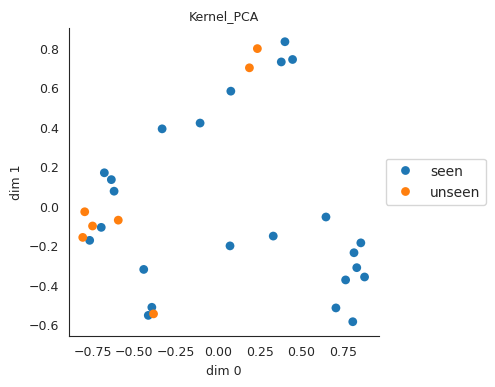

In [24]:
from cfp.plotting import plot_condition_embedding
fig = plot_condition_embedding(cond_embedding, embedding="Kernel_PCA", hue="type")

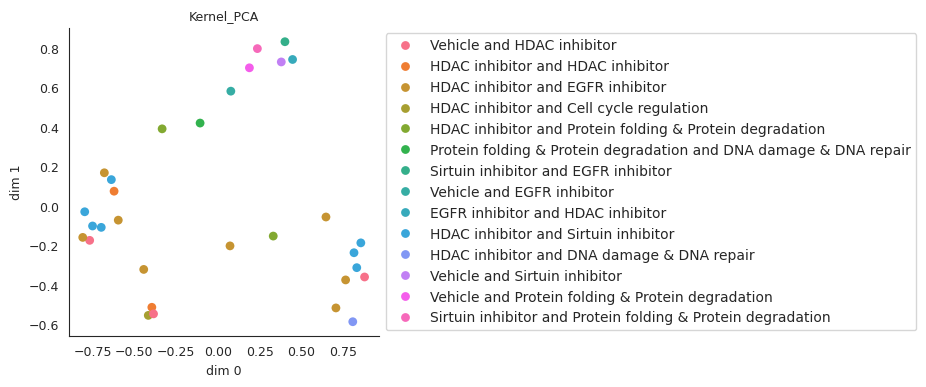

In [25]:
fig = plot_condition_embedding(cond_embedding, embedding="Kernel_PCA", hue="pathway")

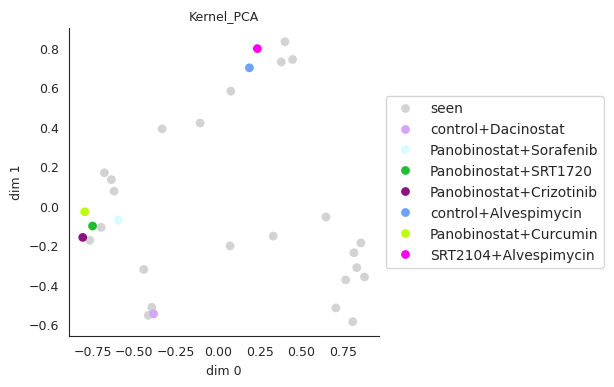

In [32]:
combosciplex_color_dict["seen"] = "#D3D3D3"
fig = plot_condition_embedding(cond_embedding, embedding="Kernel_PCA", hue="condition_adapted", col_dict=combosciplex_color_dict)

In [34]:
cond_embedding["condition"] = cond_embedding.index
cond_embedding.to_csv("cond_embedding_split_3.csv")